# 2021-11-29 Slight adjustment of the handling of safety margins

Results below are for commit: https://github.com/gmarkkula/COMMOTIONSFramework/commit/51554d63d9d90254c9bcdf0a88cba6cdd753431e (Rerunning the code below for other commits is not likely/guaranteed to give the same results.)

After thinking through the problem wrt safety margins that I identified in the 2021-11-27 diary notes, I think that the correct way to go is to apply the safety margins only for the ego agent, in `sc_scenario.get_access_order_implications()`; this is actually already how I had it described in the SCPaper README's description of the model. ("The estimated acceleration for an agent $X$ to pass first(/second) is the acceleration needed to reach a safety margin distance $D_\mathrm{s}$ past(/before) the conflict space, at a time $T_\mathrm{s}$ before(/after) the other agent $\lnot X$ enters(/exits) the conflict space.") However, in the previous implementation of `sc_scenario.get_access_order_implications()`, I applied the safety margin distance $D_\mathrm{s}$ also to the other agent's entry/exit into the conflict space.

## Init

In [1]:
# append root folder of repo to PYTHONPATH (https://stackoverflow.com/questions/714063/importing-modules-from-parent-folder)
import sys
from pathlib import Path
parent_path = str(Path('.').absolute().parent)
if not (parent_path in sys.path):
    sys.path.append(parent_path)
    sys.path.append(parent_path + '/SCPaper')
print(sys.path)

# imports needed to run the simulations
import numpy as np
import commotions
import sc_scenario
import sc_scenario_perception
from sc_scenario_helper import CtrlType

['C:\\GITHUB\\COMMOTIONSFramework\\diary notebooks', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\python39.zip', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\DLLs', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64', '', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\win32', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\win32\\lib', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\Pythonwin', 'C:\\WinPython\\WPy64-3920\\python-3.9.2.amd64\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\tragma\\.ipython', 'C:\\GITHUB\\COMMOTIONSFramework', 'C:\\GITHUB\\COMMOTIONSFramework/SCPaper']


## Unit tests, reproducing earlier results

### Basics - check!

Just the base model, no interaction.

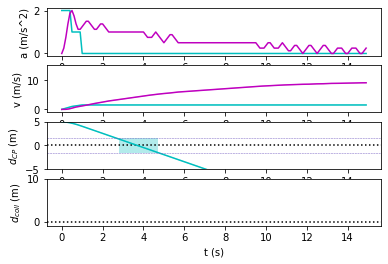

In [2]:
NAMES = ('P', 'V')
WIDTHS = (1.5, 1.5) # setting widths/lengths corresponding to the old default
LENGTHS = (1.5, 1.5) # setting sc_scenario.SHARED_PARAMS.d_C = 1.5
CTRL_TYPES = (CtrlType.SPEED, CtrlType.ACCELERATION) 
INITIAL_POSITIONS = np.array([[0,-5], [400, 0]])
GOALS = np.array([[0, 5], [-50, 0]])
SPEEDS = np.array((0, 0))

optional_assumptions = sc_scenario.get_assumptions_dict(
        default_value = False, oVA = True, oBEo = False, oBEv = False, oAI = False, oEA = False)
sc_simulation = sc_scenario.SCSimulation(
        CTRL_TYPES, WIDTHS, LENGTHS, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
        end_time = 15, optional_assumptions = optional_assumptions,
        agent_names = NAMES)
sc_simulation.run()
sc_simulation.do_plots(kinem_states = True)

Baseline kinematics, base model. Also ok.

Initial car distance 30 m:


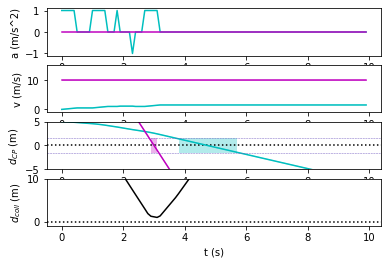

Initial car distance 40 m:


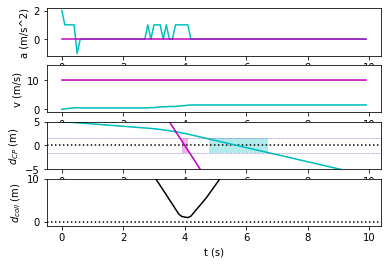

Initial car distance 50 m:


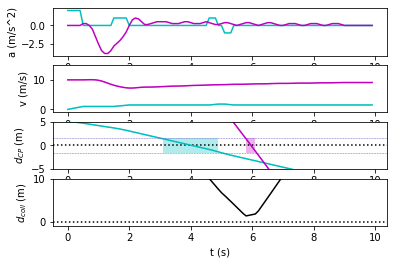

In [3]:
SPEEDS = np.array((0, 10))
PED_Y0 = -5
CONST_ACCS = (None, None)
AFF_VAL_FCN = True
optional_assumptions = sc_scenario.get_assumptions_dict(
        default_value = False, oVA = AFF_VAL_FCN, oBEo = False, oBEv = False, oAI = False, oEA = False)
(params, params_k) = sc_scenario.get_default_params(oVA = AFF_VAL_FCN)


def run_baseline_kinematics(dist0s = (30, 40, 50), 
                            plot_beh_probs = False, plot_beh_activs = False, 
                            plot_beh_accs = False, plot_looming = False, 
                            ped_snaps = None, veh_snaps = None):
    for dist0 in dist0s:
        INITIAL_POSITIONS = np.array([[0, PED_Y0], [dist0, 0]])
        sc_simulation = sc_scenario.SCSimulation(
                CTRL_TYPES, WIDTHS, LENGTHS, GOALS, INITIAL_POSITIONS, initial_speeds = SPEEDS, 
                end_time = 10, optional_assumptions = optional_assumptions,
                agent_names = NAMES, const_accs = CONST_ACCS, params = params,
                snapshot_times = (ped_snaps, veh_snaps))
        sc_simulation.run()
        print('Initial car distance %d m:' % dist0)
        sc_simulation.do_plots(kinem_states = True, beh_probs = plot_beh_probs,
                              beh_activs = plot_beh_activs, beh_accs = plot_beh_accs,
                              looming = plot_looming)

run_baseline_kinematics()

And here is the same after restoring the pre-safety-margin settings. Again ok.

Initial car distance 30 m:


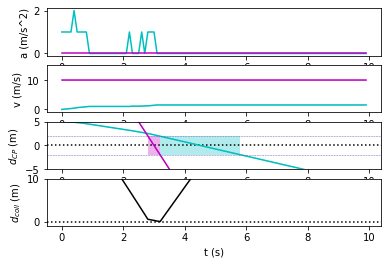

Initial car distance 40 m:


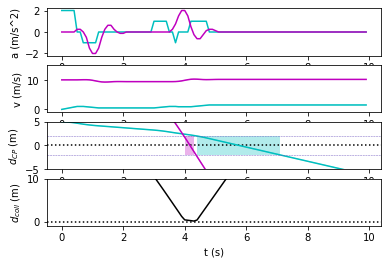

Initial car distance 50 m:


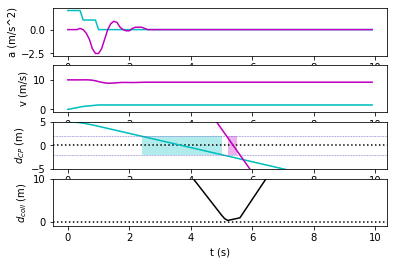

In [4]:
WIDTHS = (2, 2) # setting widths/lengths corresponding to the old default
LENGTHS = (2, 2) # setting sc_scenario.SHARED_PARAMS.d_C = 2
params.T_s = 0
params.D_s = 0
run_baseline_kinematics()

### Testing the `oBEo` etc sequence - check!

Getting back the same results as in the 2021-11-09 notes:

Turning on oBEo:
Initial car distance 40 m:


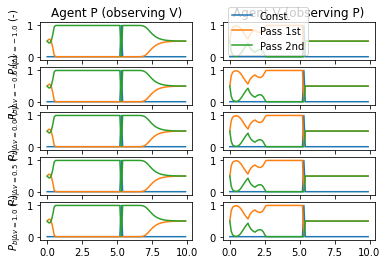

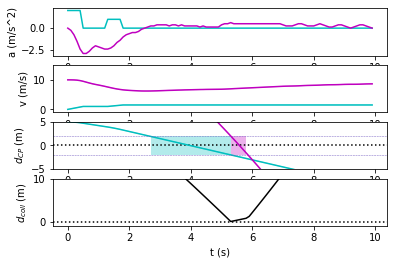

Turning on oBEv:
Initial car distance 40 m:


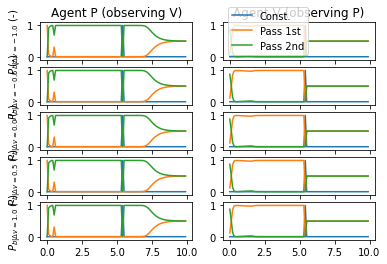

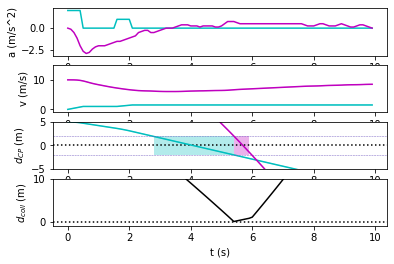

Turning on oAI:
Initial car distance 40 m:


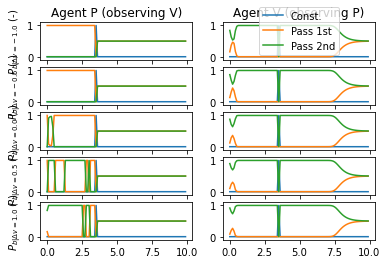

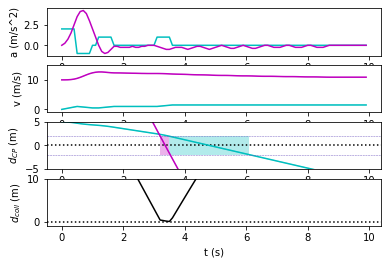

In [5]:
params.T_O1 = 0.1 
params.T_Of = 0.5
params.sigma_O = 0.01
params.beta_V = 160

def run_oBEo_etc_seq():
    global optional_assumptions
    print('Turning on oBEo:')
    optional_assumptions = sc_scenario.get_assumptions_dict(
            default_value = False, oVA = AFF_VAL_FCN, oBEo = True)
    run_baseline_kinematics(dist0s = (40,), plot_beh_probs = True)
    print('Turning on oBEv:')
    optional_assumptions = sc_scenario.get_assumptions_dict(
            default_value = False, oVA = AFF_VAL_FCN, oBEo = True, oBEv = True)
    run_baseline_kinematics(dist0s = (40,), plot_beh_probs = True)
    print('Turning on oAI:')
    optional_assumptions = sc_scenario.get_assumptions_dict(
            default_value = False, oVA = AFF_VAL_FCN, oBEo = True, oBEv = True, oAI = True)
    run_baseline_kinematics(dist0s = (40,), plot_beh_probs = True)
run_oBEo_etc_seq()

## Rerunning the simulation in which I spotted the problem

We can see below that this has now fixed the problem where neither outcome was valid for the pedestrian if the vehicle passed first. However, at least for this model parameterisation the behaviour of the pedestrian remains unchanged; it prefers to accelerate in front of the vehicle, because even though that action has slightly lower value if the vehicle is passing first (11.3 instead of 13.6), because of the looming aversion it has a higher value if the vehicle is passing second (7.6 instead of 6.1), and the pedestrian is at this moment judging it more probable that the vehicle is indeed passing second. Possibly the code modification means that other parameterisations of this model will be able to exhibit pedestrian hesitation in this scenario, but I'm not sure.

C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds
C:\GITHUB\COMMOTIONSFramework\sc_scenario_helper.py:220: RuntimeWarning: divide by zero encountered in true_divide
  side_app_arr_times = side_dists / speeds


Initialising and running simulation took 1.230 s.


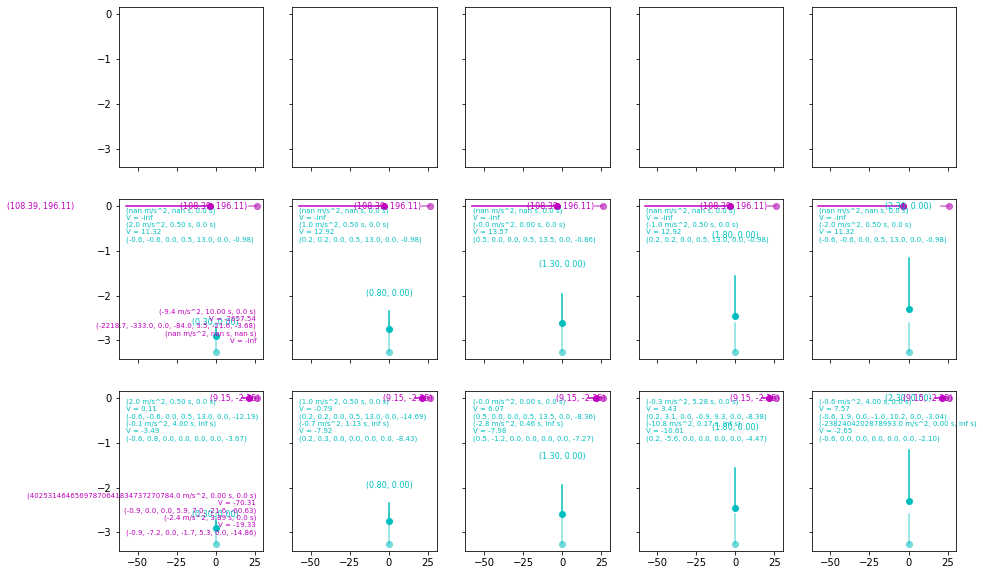

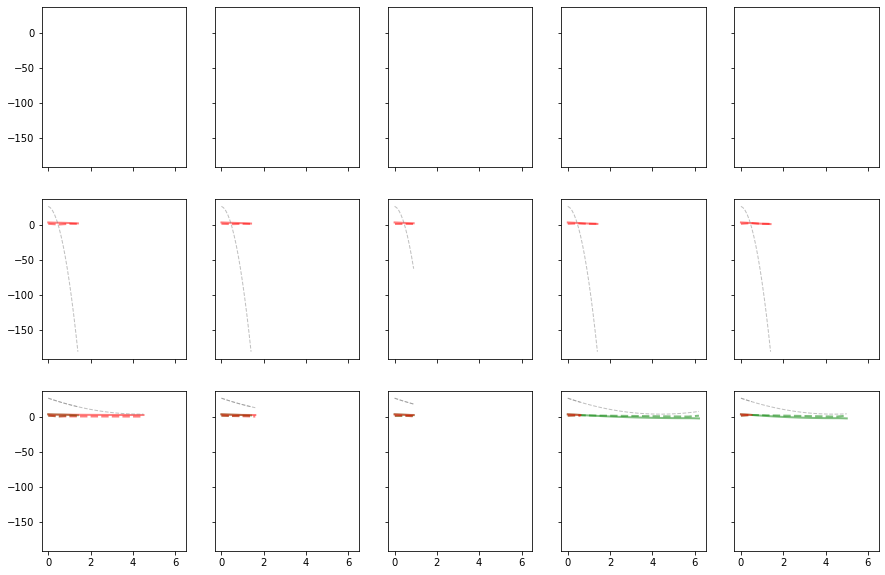

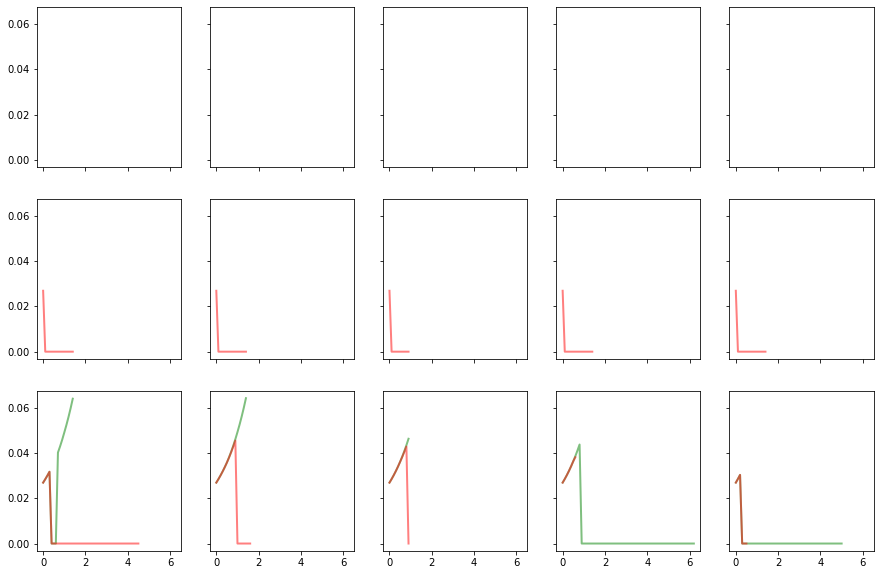

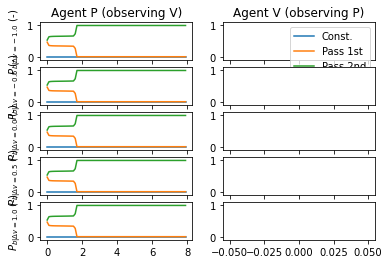

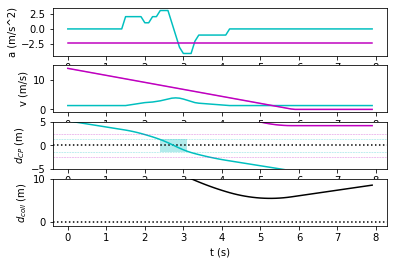

Metric PedHesitateVehYield_ped_av_speed = 1.4863636363636366


{'PedHesitateVehYield_ped_av_speed': 1.4863636363636366}

In [6]:
import copy
import time
import sc_scenario
import sc_fitting

# set model
MODEL = 'oVAaoVAloBEv'
# get assumptions and default parameters for chosen model
assumptions = sc_scenario.get_assumptions_dict_from_string(MODEL)
params = copy.deepcopy(sc_fitting.DEFAULT_PARAMS)
params_k = copy.deepcopy(sc_fitting.get_default_params_k(MODEL))

# set remaining model parameters
params.T_delta = 10
params.thetaDot_1 = 0.005
params.beta_V = 1

# set scenario to run
SCENARIO = sc_fitting.ONE_AG_SCENARIOS['PedHesitateVehYield']

# simulate and plot
tic = time.perf_counter()
sim = sc_fitting.simulate_scenario(SCENARIO, assumptions, params, params_k, 
                                   snapshots=((1.5,), None)
                                   )
toc = time.perf_counter()
print('Initialising and running simulation took %.3f s.' % (toc - tic,))
sim.do_plots(kinem_states=True, beh_probs=True)
sc_fitting.get_metrics_for_scenario(SCENARIO, sim, verbose=True)